<a href="https://colab.research.google.com/github/JasonArmitage-res/Lab_Multimodal_ML/blob/master/Multimodal_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install 'regex==2019.11.1' --force-reinstall

In [0]:
import torch
!pip install transformers
from transformers import BertTokenizer
from transformers import BertConfig
from transformers import BertModel
from nltk import tokenize

In [0]:
import nltk
from transformers import BertTokenizer
from nltk import tokenize
#nltk.download('punkt')


#Generates formatted input (for Bert) from text


class BertInput () :
    
    def __init__(self, max_input_length = 512):

        self.indexed_tokens = []
        self.segment_ids = []
        self.masked_ids = []
        self.max_input_length = max_input_length

    def GetIndexedTokens(self, text):
        
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        #tagged_text = self.AddSpecialTokens(text)
        #tokenized_text = tokenizer.tokenize(tagged_text)
        tokenized_text = tokenizer.tokenize(text)
        tokenized_text.append("[SEP]")
        tokenized_text.insert(0,"[CLS]")
        self.indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    '''
    def AddSpecialTokens (self, text) : 
    
        #add [CLS] token in the beggining of every text, [SEP] after every sentence
        sentences = tokenize.sent_tokenize('[CLS] ' + text)
        sentences = [x + ' [SEP]' for x in sentences]
        return (' '.join(sentences))
    '''

    def GetSegmentIds(self) :
        
        self.segment_ids = [1] * len(self.indexed_tokens)
 
    def GetMaskedIds(self) :
        
        self.masked_ids = [1] * len(self.indexed_tokens)

    def Padding(self) :

        if(len(self.indexed_tokens) < self.max_input_length) :
           padding = [0]*(self.max_input_length - len(self.indexed_tokens))
           self.indexed_tokens += padding
           self.segment_ids += padding
           self.masked_ids += padding
        else :
           del self.indexed_tokens[self.max_input_length:]
           del self.segment_ids[self.max_input_length:]
           del self.masked_ids[self.max_input_length:]

    def GenerateBertInput(self, text) :

        self.GetIndexedTokens(text)
        self.GetSegmentIds()
        self.GetMaskedIds()
        self.Padding()
        #result = [torch.tensor(self.indexed_tokens),torch.tensor(self.segment_ids),torch.tensor(self.masked_ids)]
        
        return [self.indexed_tokens, self.segment_ids, self.masked_ids]


In [0]:
#ref: https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mighty-transformer-69714fa3fb3d
from transformers import BertModel
from torch import nn

class BertMultiLabelClassifier(nn.Module):

    def __init__(self, config, num_labels = 23, dropout = 0.1):

        super(BertMultiLabelClassifier, self).__init__()
        self.num_labels = num_labels
        self.base_model = BertModel.from_pretrained('bert-base-uncased', config=config)
        self.hidden_layer = torch.nn.Linear(config.hidden_size, num_labels)
        self.output_layer = torch.nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, indexed_tokens, segment_ids=None, masked_ids=None):
        
        pooled_output = self.base_model(indexed_tokens, segment_ids, masked_ids)
        dropped_layer = self.dropout(pooled_output[1])
        logits = self.hidden_layer(dropped_layer)
        if(self.training) :
            return logits
        else :
            output = self.output_layer(logits)
            return output


    def freeze_bert_encoder(self):
        for param in self.base_model.parameters():
            param.requires_grad = False


    def unfreeze_bert_encoder(self):
        for param in self.base_model.named_parameters():
            param.requires_grad = True
    

In [0]:
import pandas as pd
#data = pd.read_pickle("/content/drive/My Drive/Dataset/mm_imdb_sampled.pkl")
Data_train_tensor = torch.load("/content/drive/My Drive/Dataset/Data_train_tensor.pt")
Data_test_tensor = torch.load("/content/drive/My Drive/Dataset/Data_test_tensor.pt")
Labels_train_tensor = torch.load("/content/drive/My Drive/Dataset/Labels_train_tensor.pt")
Labels_test_tensor = torch.load("/content/drive/My Drive/Dataset/Labels_test_tensor.pt")

In [0]:
import numpy as np
#np.save("/content/drive/My Drive/Dataset/Label_names",e)
Label_names = list(np.load("/content/drive/My Drive/Dataset/Label_names.npy", allow_pickle=True))

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

def Train_Test_Split(data , test_data_fraction = 0.2) :
    
    mlb = MultiLabelBinarizer()
    data_genres_one_hot_encoding = mlb.fit_transform(data['genres'])
    Label_names = mlb.classes_
    data_genres_one_hot_encoding = pd.DataFrame(data_genres_one_hot_encoding, columns = mlb.classes_)
    Data_train, Data_test, Labels_train, Labels_test = train_test_split(data, data_genres_one_hot_encoding, test_size = test_data_fraction)
    Labels_train = torch.tensor(Labels_train.values)
    Labels_test = torch.tensor(Labels_test.values)

    return (Data_train, Data_test, Labels_train, Labels_test, Label_names)


In [0]:
#ref: https://huggingface.co/transformers/main_classes/optimizer_schedules.html

from transformers import AdamW

config = BertConfig.from_pretrained('bert-base-uncased')
bert = BertMultiLabelClassifier(config)
bert = bert.cuda()

#do not train the Bert model
bert.freeze_bert_encoder()

'''
param_optimizer = list(bert.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)
                     
'''

optimizer = AdamW(bert.parameters(), lr=2e-5, eps = 1e-8)

In [0]:
#source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [0]:
#source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

def Plot_Training_Epoch_Loss(epoch_loss_set) :

  sns.set(style='darkgrid')
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)
  plt.plot(epoch_loss_set, 'b-o')
  plt.title("Training loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  Batch :  30  , Time elapsed :  0:00:48
  Batch :  60  , Time elapsed :  0:01:35
  Batch :  90  , Time elapsed :  0:02:22
  Batch :  120  , Time elapsed :  0:03:10
  Batch :  150  , Time elapsed :  0:03:57



Epoch:  17%|█▋        | 1/6 [04:24<22:03, 264.67s/it]


Train loss for epoch:  0.36880790247094064

Training epoch took: 0:04:25
  Batch :  30  , Time elapsed :  0:00:47
  Batch :  60  , Time elapsed :  0:01:35
  Batch :  90  , Time elapsed :  0:02:22
  Batch :  120  , Time elapsed :  0:03:10
  Batch :  150  , Time elapsed :  0:03:57



Epoch:  33%|███▎      | 2/6 [08:49<17:38, 264.73s/it]


Train loss for epoch:  0.3684377822847593

Training epoch took: 0:04:25
  Batch :  30  , Time elapsed :  0:00:48
  Batch :  60  , Time elapsed :  0:01:35
  Batch :  90  , Time elapsed :  0:02:23
  Batch :  120  , Time elapsed :  0:03:10
  Batch :  150  , Time elapsed :  0:03:58



Epoch:  50%|█████     | 3/6 [13:14<13:14, 264.85s/it]


Train loss for epoch:  0.36824716077674

Training epoch took: 0:04:25
  Batch :  30  , Time elapsed :  0:00:48
  Batch :  60  , Time elapsed :  0:01:35
  Batch :  90  , Time elapsed :  0:02:23
  Batch :  120  , Time elapsed :  0:03:10
  Batch :  150  , Time elapsed :  0:03:58



Epoch:  67%|██████▋   | 4/6 [17:40<08:50, 265.04s/it]


Train loss for epoch:  0.3685862272977829

Training epoch took: 0:04:25
  Batch :  30  , Time elapsed :  0:00:48
  Batch :  60  , Time elapsed :  0:01:35
  Batch :  90  , Time elapsed :  0:02:23
  Batch :  120  , Time elapsed :  0:03:10
  Batch :  150  , Time elapsed :  0:03:58



Epoch:  83%|████████▎ | 5/6 [22:05<04:25, 265.12s/it]


Train loss for epoch:  0.3683128436761243

Training epoch took: 0:04:25
  Batch :  30  , Time elapsed :  0:00:48
  Batch :  60  , Time elapsed :  0:01:35
  Batch :  90  , Time elapsed :  0:02:23
  Batch :  120  , Time elapsed :  0:03:10
  Batch :  150  , Time elapsed :  0:03:58



Epoch: 100%|██████████| 6/6 [26:30<00:00, 265.08s/it]



Train loss for epoch:  0.3683340145008905

Training epoch took: 0:04:25


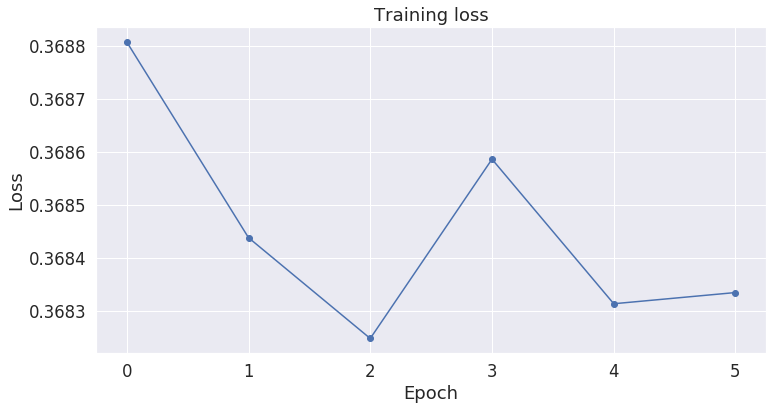

In [0]:
#ref: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#from torch.optim import Adam
from tqdm import tqdm, trange

BATCH_SIZE = 32
EPOCHS = 6
NUM_LABELS = 23

train_dataset = TensorDataset(Data_train_tensor, Labels_train_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_dataset = TensorDataset(Data_test_tensor, Labels_test_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

train_loss_set = []

for _ in trange(EPOCHS, desc="Epoch"):

    bert.train()
    
    epoch_loss = 0

    # Measure how long the training epoch takes.
    t0 = time.time()
    
    for step_num, batch_data in enumerate(train_dataloader):

        # Progress update every 30 batches.
        if step_num % 30 == 0 and not step_num == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch : ',step_num, ' , Time elapsed : ',elapsed)

        token_ids, labels = tuple(t.to(device) for t in batch_data)
        optimizer.zero_grad()
        logits = bert(token_ids)
        loss_fct = BCEWithLogitsLoss()
        batch_loss = loss_fct(logits.view(-1, NUM_LABELS).float(), labels.view(-1, NUM_LABELS).float())
        batch_loss.backward()
        #scheduler.step()
        optimizer.step()
        epoch_loss += batch_loss.item()

    avg_epoch_loss = epoch_loss/len(train_dataloader)
    print("\nTrain loss for epoch: ",avg_epoch_loss)
    print("\nTraining epoch took: {:}".format(format_time(time.time() - t0)))
    train_loss_set.append(avg_epoch_loss)

torch.save(bert.state_dict(), "/content/drive/My Drive/Dataset/bert_unimodal.pt")
Plot_Training_Epoch_Loss(train_loss_set)

In [0]:
config = BertConfig.from_pretrained('bert-base-uncased')
bert = BertMultiLabelClassifier(config)
bert = bert.cuda()

#Later to restore:
bert.load_state_dict(torch.load("/content/drive/My Drive/Dataset/bert_unimodal.pt"))

<All keys matched successfully>

In [0]:
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#from torch.optim import Adam
from tqdm import tqdm, trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dataset = TensorDataset(Data_test_tensor, Labels_test_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

In [0]:
# Testing

# Put model in evaluation mode to evaluate loss on the test set
bert.eval()

results = pd.DataFrame(0, index=['Recall','Precision','F_Score'], columns=['micro', 'macro', 'weighted', 'samples']).astype(float)

# Evaluate data for one epoch
for batch_data in test_dataloader:
      
      token_ids, labels = tuple(t.to(device) for t in batch_data)
      
      # Telling the model not to compute or store gradients, saving memory and speeding up validation
      # Forward pass, calculate logit predictions
      with torch.no_grad():
        output = bert(token_ids)

      threshold = torch.Tensor([0.2]).to(device)
      predictions = (output > threshold).int()

      # Move preds and labels to CPU
      predictions = predictions.detach().cpu().numpy()
      labels = labels.to('cpu').numpy()
      
      results = Get_Metrics(labels, predictions, results)
    
results = results/len(test_dataloader)
print("Test data metrics : \n")
results

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Test data metrics : 



,micro,macro,weighted,samples
Recall,0.361230,0.156826,0.361230,0.368941
Precision,0.318757,0.075197,0.170724,0.323082
F_Score,0.338061,0.086607,0.209817,0.330291


In [0]:
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm, trange
#!pip install transformers
from transformers import BertConfig, AdamW
from sklearn import metrics
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import pandas as pd
import time
import datetime


class Training_Testing_Bert():

    def __init__(self, Data_train_tensor, Labels_train_tensor, Data_test_tensor, Labels_test_tensor, 
                 Label_names = None, batch_size = 16, epochs = 5, freeze_bert = True, sigmoid_thresh = 0.2, 
                 optim_lr = 2e-5, num_labels = 23):
      
      self.config = BertConfig.from_pretrained('bert-base-uncased')
      self.bert = BertMultiLabelClassifier(config).cuda()
      
      #do not train the Bert model
      if(freeze_bert) :
        self.bert.freeze_bert_encoder()

      self.label_names = Label_names
      self.num_labels = num_labels
      self.batch_size = batch_size
      self.optim_lr = optim_lr
      self.epochs = epochs
      self.sigmoid_thresh = sigmoid_thresh
      self.optimizer = self.SetOptimizer()
      #self.scheduler = self.SetScheduler()
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.results = pd.DataFrame(0, index=['Recall','Precision','F_Score'], columns=['micro', 'macro', 'weighted', 'samples']).astype(float)
      self.epoch_loss_set = []
      self.train_dataloader = self.SetTrainDataloader(Data_train_tensor, Labels_train_tensor)
      self.test_dataloader = self.SetTestDataloader(Data_test_tensor, Labels_test_tensor)


    def SetOptimizer(self) :

      optimizer = AdamW(self.bert.parameters(), self.optim_lr, eps = 1e-6)
      return(optimizer)

    
    '''
    def SetScheduler(self) :

      scheduler =
      return(scheduler) 
    '''


    def Get_Metrics(self, actual, predicted) :

      #acc = metrics.accuracy_score(actual, predicted)
      #hamming = metrics.hamming_loss(actual, predicted)
      #(metrics.roc_auc_score(actual, predicted, average=average)
      averages = ('micro', 'macro', 'weighted', 'samples')
      for average in averages:
          precision, recall, fscore, _ = metrics.precision_recall_fscore_support(actual, predicted, average=average)
          self.results[average]['Recall'] += recall
          self.results[average]['Precision'] += precision
          self.results[average]['F_Score'] += fscore


    #source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    def Plot_Training_Epoch_Loss(self) :

      sns.set(style='darkgrid')
      sns.set(font_scale=1.5)
      plt.rcParams["figure.figsize"] = (12,6)
      plt.plot(self.epoch_loss_set, 'b-o')
      plt.title("Training loss")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.show()


    #source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    def format_time(self, elapsed):
      '''
      Takes a time in seconds and returns a string hh:mm:ss
      '''
      # Round to the nearest second.
      elapsed_rounded = int(round((elapsed)))
      return str(datetime.timedelta(seconds=elapsed_rounded))


    def SetTrainDataloader(self, Data_train_tensor, Labels_train_tensor) :

      train_dataset = TensorDataset(Data_train_tensor, Labels_train_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size = self.batch_size)
      return(train_dataloader)


    def SetTestDataloader(self, Data_test_tensor, Labels_test_tensor) :
      
      test_dataset = TensorDataset(Data_test_tensor, Labels_test_tensor)
      test_sampler = SequentialSampler(test_dataset)
      test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size = self.batch_size)
      return(test_dataloader)



    def Train_Bert(self) :

      for _ in trange(self.epochs, desc="Epoch"):
        
        self.bert.train()
        epoch_loss = 0

        # Measure how long the training epoch takes.
        t0 = time.time()
    
        for step_num, batch_data in enumerate(self.train_dataloader):

          # Progress update every 30 batches.
          if step_num % 30 == 0 and not step_num == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch : ',step_num, ' , Time elapsed : ',elapsed)

          token_ids, labels = tuple(t.to(self.device) for t in batch_data)
          self.optimizer.zero_grad()
          logits = self.bert(token_ids)
          loss_fct = BCEWithLogitsLoss()
          batch_loss = loss_fct(logits.view(-1, self.num_labels).float(), labels.view(-1, self.num_labels).float())
          batch_loss.backward()
          #scheduler.step()
          self.optimizer.step()
          epoch_loss += batch_loss.item()

      avg_epoch_loss = epoch_loss/len(self.train_dataloader)
      print("\nTrain loss for epoch: ",avg_epoch_loss)
      print("\nTraining epoch took: {:}".format(format_time(time.time() - t0)))
      self.epoch_loss_set.append(avg_epoch_loss)

      torch.save(self.bert.state_dict(), "/content/drive/My Drive/Dataset/bert_unimodal.pt")
      self.Plot_Training_Epoch_Loss()
    

    def Test_Bert(self) :

      # Put model in evaluation mode to evaluate loss on the test set
      self.bert.eval()

      for batch_data in self.test_dataloader:
  
        token_ids, labels = tuple(t.to(device) for t in batch_data)
      
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        # Forward pass, calculate logit predictions
        with torch.no_grad():
          output = self.bert(token_ids)

        threshold = torch.Tensor([self.sigmoid_thresh]).to(self.device)
        predictions = (output > threshold).int()

        # Move preds and labels to CPU
        predictions = predictions.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()
      
        self.Get_Metrics(labels, predictions)
    
      self.results = self.results/len(self.test_dataloader)
      print("Test data metrics : \n")
      self.results
    

In [0]:

    def Get_Metrics(actual, predicted, results) :

      #acc = metrics.accuracy_score(actual, predicted)
      #hamming = metrics.hamming_loss(actual, predicted)
      #(metrics.roc_auc_score(actual, predicted, average=average)
      averages = ('micro', 'macro', 'weighted', 'samples')
      for average in averages:
          precision, recall, fscore, _ = metrics.precision_recall_fscore_support(actual, predicted, average=average)
          results[average]['Recall'] += recall
          results[average]['Precision'] += precision
          results[average]['F_Score'] += fscore
      return results 




Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  Batch :  30  , Time elapsed :  0:00:23
  Batch :  60  , Time elapsed :  0:00:45
  Batch :  90  , Time elapsed :  0:01:08
  Batch :  120  , Time elapsed :  0:01:32
  Batch :  150  , Time elapsed :  0:01:55
  Batch :  180  , Time elapsed :  0:02:18
  Batch :  210  , Time elapsed :  0:02:41
  Batch :  240  , Time elapsed :  0:03:04
  Batch :  270  , Time elapsed :  0:03:27
  Batch :  300  , Time elapsed :  0:03:50
  Batch :  330  , Time elapsed :  0:04:13




Epoch: 100%|██████████| 1/1 [04:16<00:00, 256.83s/it]




Train loss for epoch:  0.47885878264014403

Training epoch took: 0:04:17


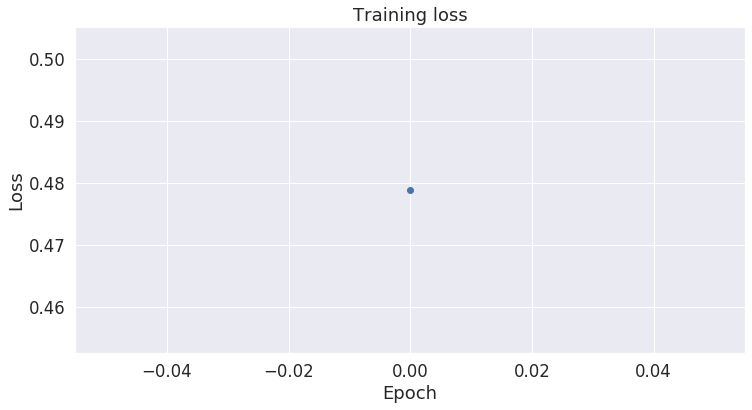

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Test data metrics : 



In [0]:
train_test = Training_Testing_Bert(Data_train_tensor, Labels_train_tensor, Data_test_tensor, Labels_test_tensor, epochs=1)
train_test.Train_Bert()
train_test.Test_Bert()

In [0]:
train_test.results

,micro,macro,weighted,samples
Recall,0.449299,0.225486,0.449299,0.448903
Precision,0.257696,0.095902,0.205193,0.280537
F_Score,0.324571,0.118018,0.257930,0.323175
